In [1]:
import os
import sys
sys.path.append('..')
import torch
import numpy as np

import pretorched.visualizers as vutils
from pretorched.models import utils as mutils
import core
import models
from data import VideoFolder, transforms
import torch.nn.functional as F

%load_ext autoreload
%autoreload 2

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
data_root = os.environ.get('DATA_ROOT', '')
datadir = os.path.join(data_root, 'DeepfakeDetection', 'test_facenet_videos')

In [25]:
dataset = VideoFolder(datadir, step=6, transform=transforms.get_transform(split='val'))
print(dataset)

Dataset VideoFolder
  Root dir: /data/datasets/DeepfakeDetection/test_facenet_videos
  Number of datapoints: 400
  Transforms (if any): Compose(
                           Compose(
                           ResizeVideo(size=256, interpolation=PIL.Image.BILINEAR)
                           CenterCropVideo(size=(224, 224))
                       )
                           CollectFrames()
                           PILVideoToTensor(rescale=True, ordering='CTHW')
                           NormalizeVideo(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], channel_dim=0)
                       )



In [26]:
ckpt_file = 'weights/FrameDetector_ssamxresnet18_all_TSNFrameSampler_seg_count-16_init-imagenet-ortho_optim-Ranger_lr-0.001_sched-CosineAnnealingLR_bs-72_best.pth.tar'
ckpt_file = 'weights/FrameDetector_samxresnet18_all_ClipSampler_seg_count-16_init-imagenet-ortho_optim-Ranger_lr-0.001_sched-CosineAnnealingLR_bs-24_best.pth.tar'
ckpt_file = 'weights/FrameDetector_samxresnet34_all_ClipSampler_clip_length-16_frame_step-5_init-imagenet-ortho_optim-Ranger_lr-0.001_sched-CosineAnnealingLR_bs-64_best.pth.tar'
basemodel_name = 'samxresnet34'
model = models.AttnFrameDetector(model=core.get_basemodel(basemodel_name), normalize=False, basemodel_name=basemodel_name)
ckpt = torch.load(ckpt_file,  map_location='cpu')
state_dict = mutils.remove_prefix(ckpt['state_dict'])
model.load_state_dict(state_dict)
model = model.to(device)
model.eval()
print()

In [43]:
name, frames, target = dataset[65]
frames = frames.unsqueeze(0).to(device)
input = frames.clone()
print(name)
print(input.min(), input.mean(), input.max())

ecumyiowzs.mp4
tensor(-2.0665, device='cuda:0') tensor(-0.1366, device='cuda:0') tensor(1.6495, device='cuda:0')


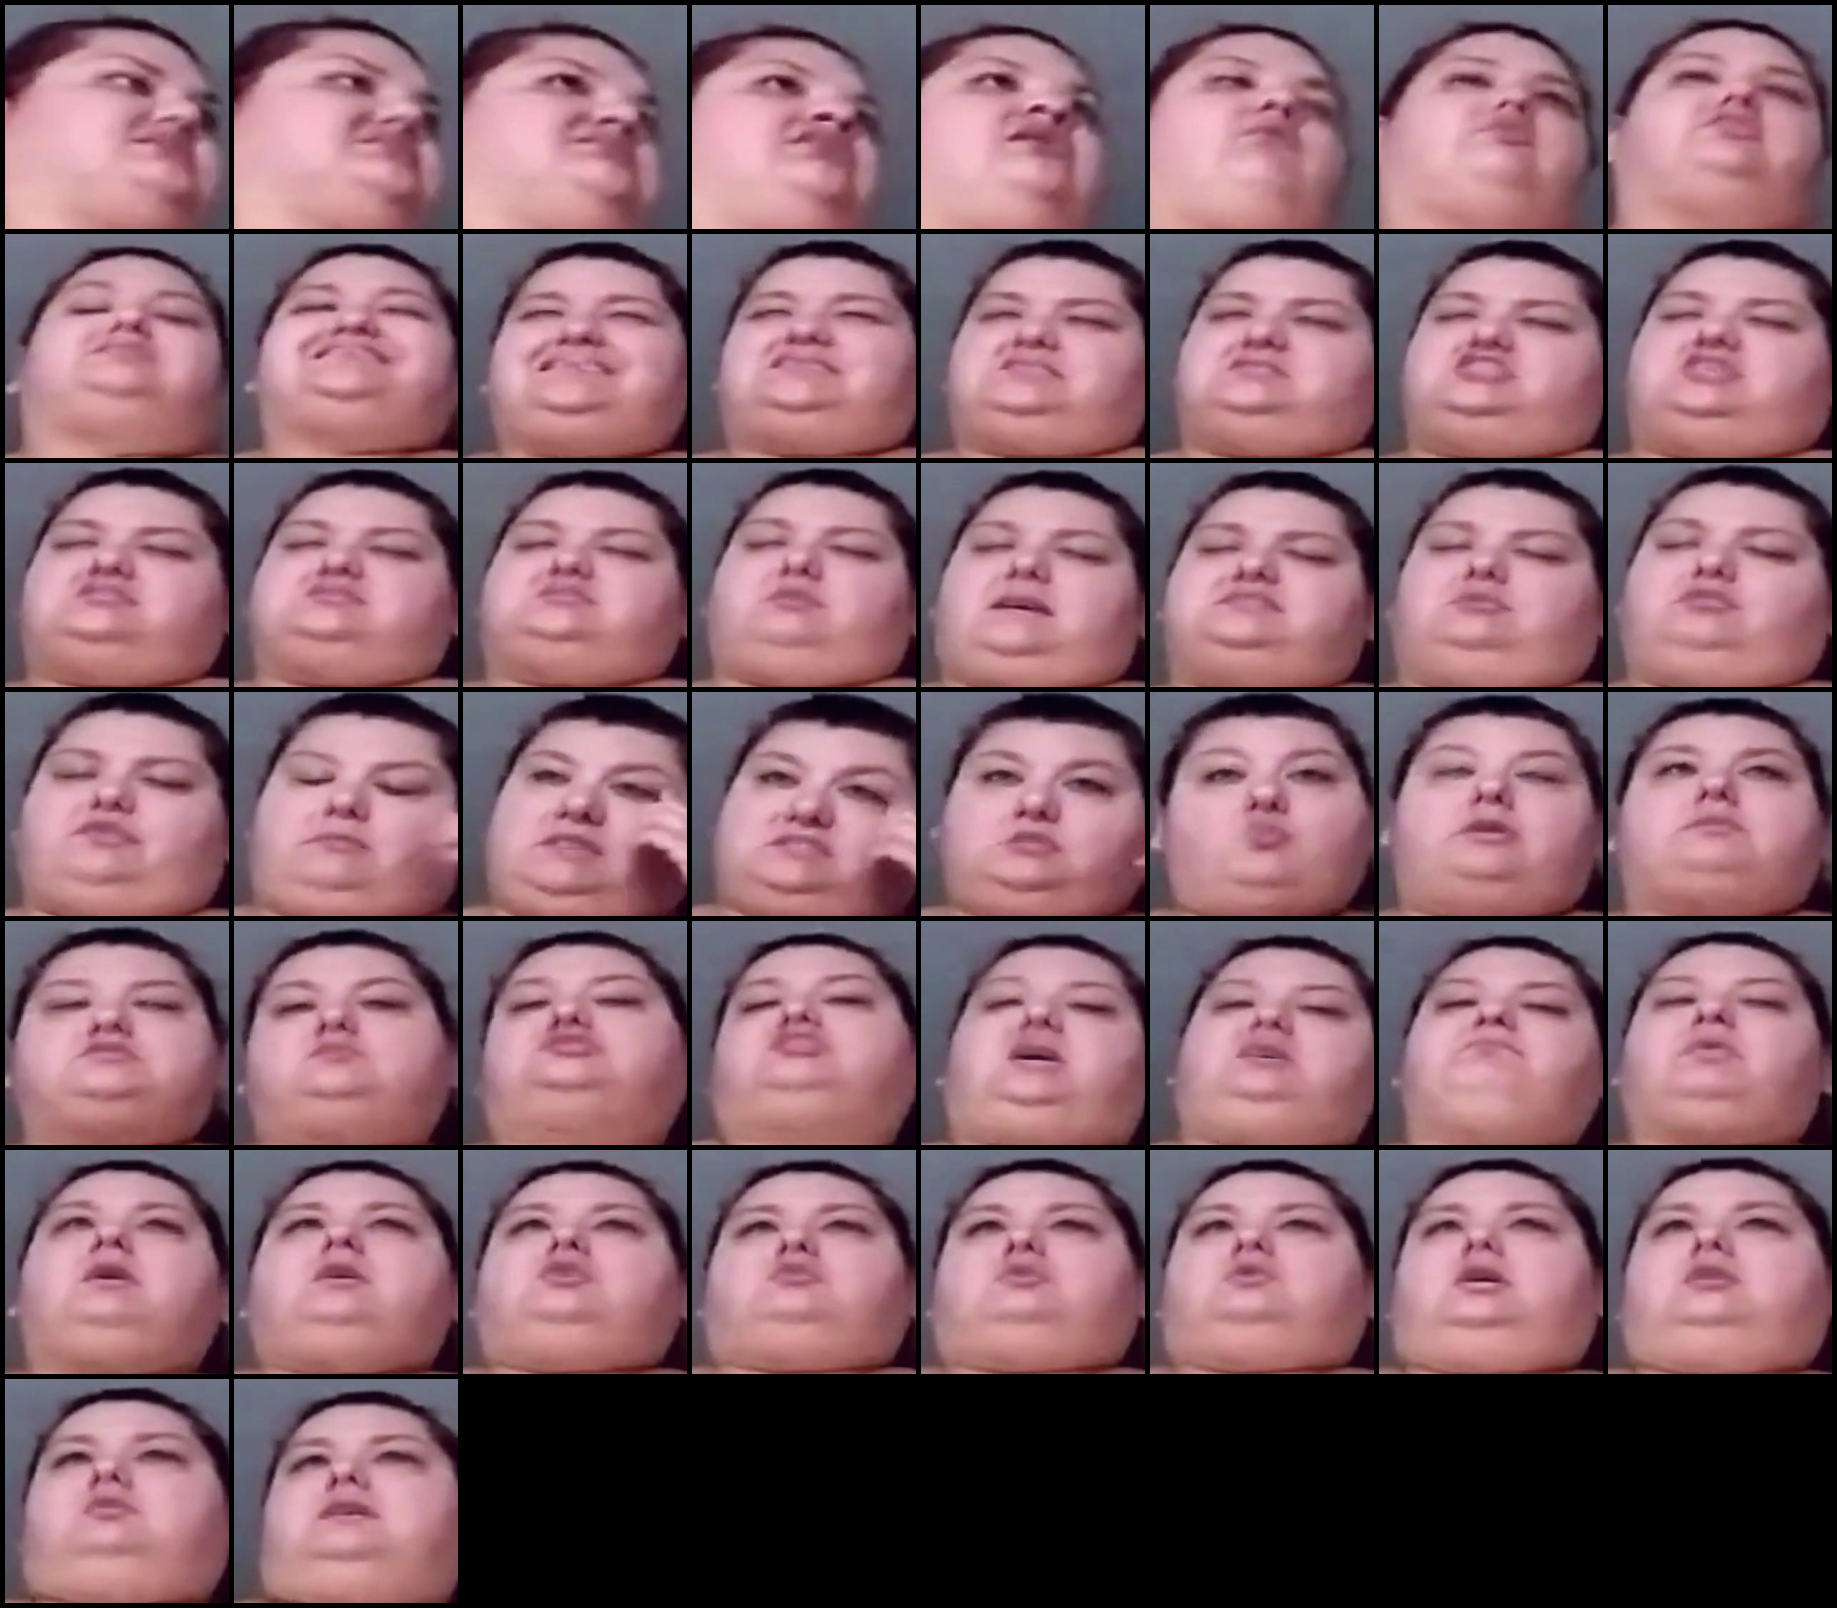

In [36]:
vutils.visualize_samples(frames.squeeze(0).transpose(0, 1))

In [37]:
with torch.no_grad():
    input = input.to(device)
    out, attn_map = model(input)


In [38]:
print(attn_map.shape)

torch.Size([1, 50, 56, 56])


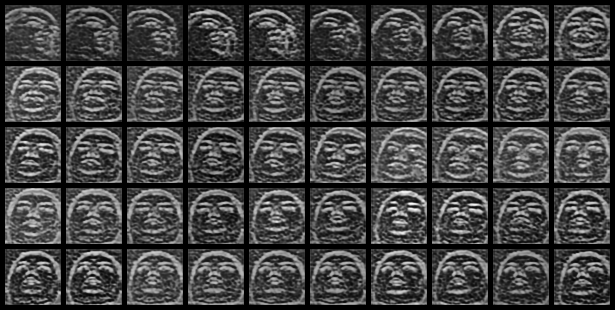

In [39]:
vutils.visualize_samples(attn_map.transpose(0, 1).repeat(1, 3, 1, 1), nrow=10)

In [40]:
attn_map_softmax = F.softmax(attn_map.view(1, attn_map.size(1), -1), dim=-1).view_as(attn_map)

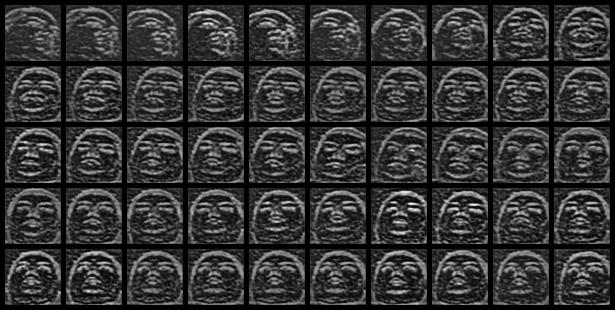

In [41]:
vutils.visualize_samples(attn_map_softmax.transpose(0, 1).repeat(1, 3, 1, 1), nrow=10)

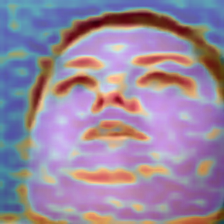

In [48]:
# Convert back to raw image
f = frames[0, :, -1].permute(1, 2, 0).cpu().numpy() 
f -= f.min()
f /= f.max()
f = (f * 255).astype(np.uint8)

# Normalize corresponding attn map
a = attn_map[0, -1].cpu().numpy()
a -= a.min()
a /= a.max()
vutils.imshow(vutils.grad_cam.apply_heatmap(a, f))

## Simple Self Attention

In [49]:
ckpt_file = '../faceforensics_neuraltextures_only/weights/FrameDetector_ssamxresnet18_all_TSNFrameSampler_seg_count-16_init-imagenet-ortho_optim-Ranger_lr-0.001_sched-CosineAnnealingLR_bs-72_best.pth.tar'
model = models.AttnFrameDetector(model=core.get_basemodel('ssamxresnet18'), normalize=False)
ckpt = torch.load(ckpt_file,  map_location='cpu')
state_dict = mutils.remove_prefix(ckpt['state_dict'])
model.load_state_dict(state_dict, strict=False)
model = model.to(device)
model.eval()
print()

In [50]:
with torch.no_grad():
    input = input.to(device)
    out, attn_map = model(input)

## An updated version

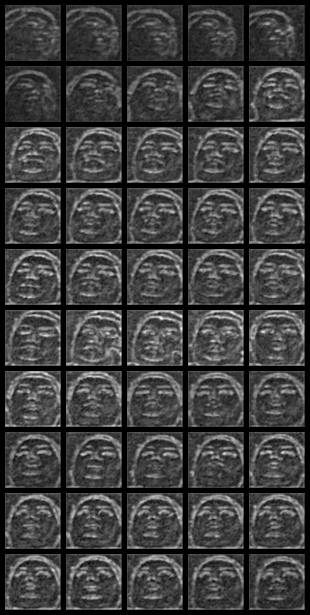

In [51]:
vutils.visualize_samples(attn_map.transpose(0, 1).repeat(1, 3, 1, 1), nrow=5)

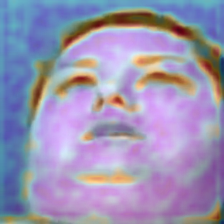

In [52]:
# Convert back to raw image
f = frames[0, :, -1].permute(1, 2, 0).cpu().numpy() 
f -= f.min()
f /= f.max()
f = (f * 255).astype(np.uint8)

# Normalize corresponding attn map
a = attn_map[0, -1].cpu().numpy()
a -= a.min()
a /= a.max()
vutils.imshow(vutils.grad_cam.apply_heatmap(a, f))